# Class 1 - Notebook 2: Variant Annotation & Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/duttaprat/BMI_503/blob/main/Class1/notebook1_variant_annotation.ipynb)

**Course**: BMI 503  
**Instructor**: Pratik Dutta  
**Institution**: Stony Brook University

## Learning Objectives
1. Work with real variant data (VCF files)
2. Annotate and filter variants
3. Perform population genetics analysis
4. Create advanced visualizations
5. Build analysis pipelines

## Understanding Variants

**Genetic variants** are DNA sequence differences between individuals.

**Types:**
- **SNP**: Single base change (A→G)
- **Insertion**: Added bases
- **Deletion**: Removed bases
- **Indel**: Combined insertion/deletion

**VCF Format** stores:
- CHROM, POS, ID, REF, ALT
- QUAL, FILTER, INFO
- Sample genotypes

In [1]:
# Install packages
!pip install PyVCF3 pandas matplotlib seaborn scipy -q
print("✅ Installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.6/988.6 kB 10.3 MB/s eta 0:00:00
✅ Installed!


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import vcf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("📦 Loaded!")

📦 Loaded!


In [3]:
# Create sample VCF
vcf_data = """##fileformat=VCFv4.2
##INFO=<ID=DP,Number=1,Type=Integer,Description="Depth">
##INFO=<ID=AF,Number=A,Type=Float,Description="Allele Freq">
##INFO=<ID=GENE,Number=1,Type=String,Description="Gene">
##INFO=<ID=EFFECT,Number=1,Type=String,Description="Effect">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tS1\tS2\tS3
chr1\t12345\trs123\tA\tG\t45\tPASS\tDP=100;AF=0.35;GENE=BRCA1;EFFECT=missense\tGT\t0/1\t1/1\t0/0
chr1\t23456\trs234\tC\tT\t89\tPASS\tDP=150;AF=0.42;GENE=TP53;EFFECT=synonymous\tGT\t0/1\t0/1\t1/1
chr1\t34567\trs345\tG\tA\t124\tPASS\tDP=200;AF=0.18;GENE=EGFR;EFFECT=nonsense\tGT\t0/0\t0/1\t0/0
chr2\t45678\trs456\tT\tC\t67\tPASS\tDP=180;AF=0.55;GENE=KRAS;EFFECT=missense\tGT\t1/1\t0/1\t1/1
chr2\t56789\trs567\tA\tT\t35\tLowQual\tDP=50;AF=0.08;GENE=BRAF;EFFECT=intron\tGT\t0/0\t0/1\t0/0
chr3\t67890\trs678\tC\tG\t156\tPASS\tDP=250;AF=0.67;GENE=MYC;EFFECT=5UTR\tGT\t1/1\t1/1\t0/1
"""

with open('variants.vcf', 'w') as f:
    f.write(vcf_data)
print("✅ Created variants.vcf")

✅ Created variants.vcf


In [4]:
# Read VCF
vcf_reader = vcf.Reader(open('variants.vcf', 'r'))
print(f"Samples: {vcf_reader.samples}")

# Show first variant
vcf_reader = vcf.Reader(open('variants.vcf', 'r'))
v = next(vcf_reader)
print(f"\nExample: {v.CHROM}:{v.POS} {v.REF}>{v.ALT[0]}")
print(f"Gene: {v.INFO['GENE']}, Effect: {v.INFO['EFFECT']}")

Samples: ['S1', 'S2', 'S3']

Example: chr1:12345 A>G
Gene: BRCA1, Effect: missense


In [5]:
# Convert to DataFrame
def vcf_to_df(file):
    reader = vcf.Reader(open(file, 'r'))
    data = []
    for r in reader:
        data.append({
            'CHROM': r.CHROM, 'POS': r.POS, 'ID': r.ID,
            'REF': r.REF, 'ALT': str(r.ALT[0]),
            'QUAL': r.QUAL, 'FILTER': 'PASS' if not r.FILTER else str(r.FILTER[0]),
            'DP': r.INFO.get('DP'), 'AF': r.INFO.get('AF', [None])[0],
            'GENE': r.INFO.get('GENE'), 'EFFECT': r.INFO.get('EFFECT')
        })
    return pd.DataFrame(data)

df = vcf_to_df('variants.vcf')
print("DataFrame:")
print(df)

DataFrame:
  CHROM    POS     ID REF ALT  QUAL   FILTER   DP    AF   GENE      EFFECT
0  chr1  12345  rs123   A   G    45     PASS  100  0.35  BRCA1    missense
1  chr1  23456  rs234   C   T    89     PASS  150  0.42   TP53  synonymous
2  chr1  34567  rs345   G   A   124     PASS  200  0.18   EGFR    nonsense
3  chr2  45678  rs456   T   C    67     PASS  180  0.55   KRAS    missense
4  chr2  56789  rs567   A   T    35  LowQual   50  0.08   BRAF      intron
5  chr3  67890  rs678   C   G   156     PASS  250  0.67    MYC        5UTR


In [6]:
# Statistics
print("Quality Statistics:")
print(df['QUAL'].describe())
print(f"\nPass rate: {len(df[df['FILTER']=='PASS'])/len(df)*100:.1f}%")

Quality Statistics:
count      6.000000
mean      86.000000
std       46.895629
min       35.000000
25%       50.500000
50%       78.000000
75%      115.250000
max      156.000000
Name: QUAL, dtype: float64

Pass rate: 83.3%


In [9]:
# Filter high quality
hq = df[(df['QUAL'] >= 50) & (df['DP'] >= 100) & (df['FILTER'] == 'PASS')]
print(f"High quality variants: {len(hq)}/{len(df)}")
print(hq[['CHROM', 'POS', 'GENE', 'EFFECT', 'QUAL']])

High quality variants: 4/6
  CHROM    POS  GENE      EFFECT  QUAL
1  chr1  23456  TP53  synonymous    89
2  chr1  34567  EGFR    nonsense   124
3  chr2  45678  KRAS    missense    67
5  chr3  67890   MYC        5UTR   156


In [10]:
# Effect analysis
print("Effect counts:")
print(df['EFFECT'].value_counts())

# High impact
high_impact = df[df['EFFECT'].isin(['missense', 'nonsense'])]
print(f"\nHigh-impact: {len(high_impact)}")

Effect counts:
EFFECT
missense      2
synonymous    1
nonsense      1
intron        1
5UTR          1
Name: count, dtype: int64

High-impact: 3


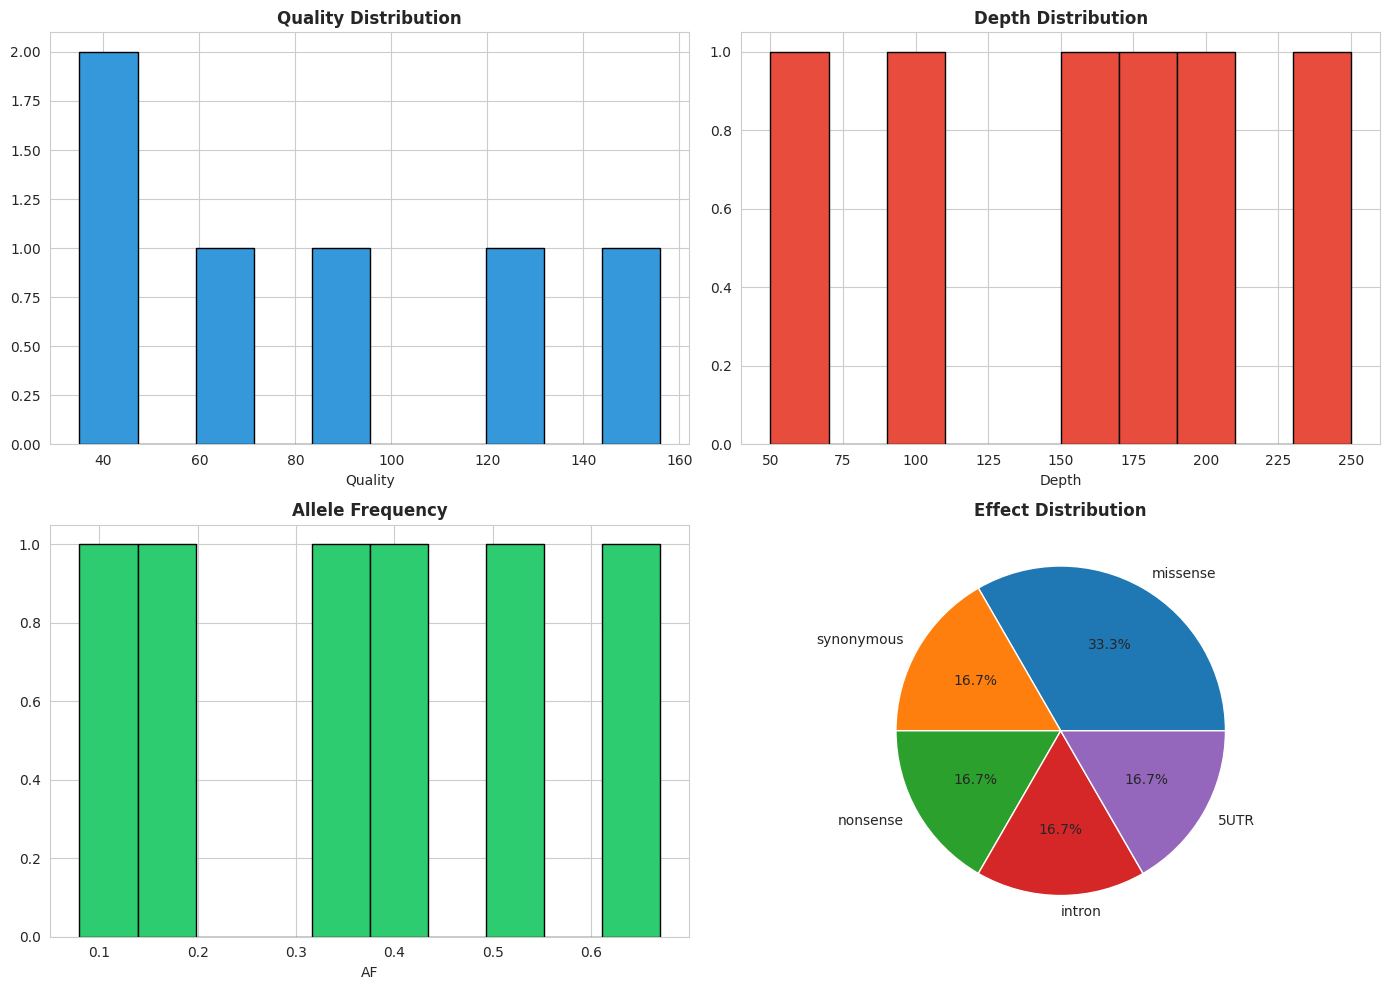

In [11]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Quality distribution
axes[0,0].hist(df['QUAL'], bins=10, color='#3498db', edgecolor='black')
axes[0,0].set_title('Quality Distribution', fontweight='bold')
axes[0,0].set_xlabel('Quality')

# Depth distribution
axes[0,1].hist(df['DP'], bins=10, color='#e74c3c', edgecolor='black')
axes[0,1].set_title('Depth Distribution', fontweight='bold')
axes[0,1].set_xlabel('Depth')

# Allele frequency
axes[1,0].hist(df['AF'], bins=10, color='#2ecc71', edgecolor='black')
axes[1,0].set_title('Allele Frequency', fontweight='bold')
axes[1,0].set_xlabel('AF')

# Effect pie
effects = df['EFFECT'].value_counts()
axes[1,1].pie(effects.values, labels=effects.index, autopct='%1.1f%%')
axes[1,1].set_title('Effect Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

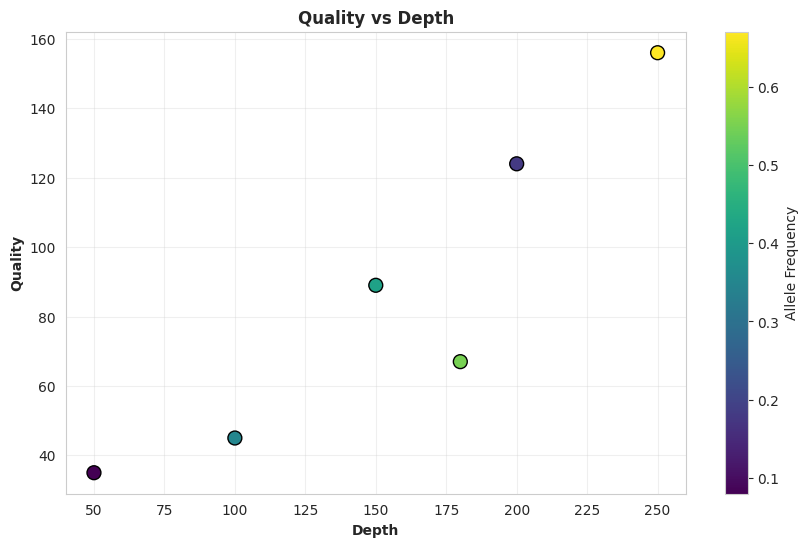

In [12]:
# Quality vs Depth scatter
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['DP'], df['QUAL'], c=df['AF'],
                     cmap='viridis', s=100, edgecolors='black')
plt.colorbar(scatter, label='Allele Frequency')
plt.xlabel('Depth', fontweight='bold')
plt.ylabel('Quality', fontweight='bold')
plt.title('Quality vs Depth', fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

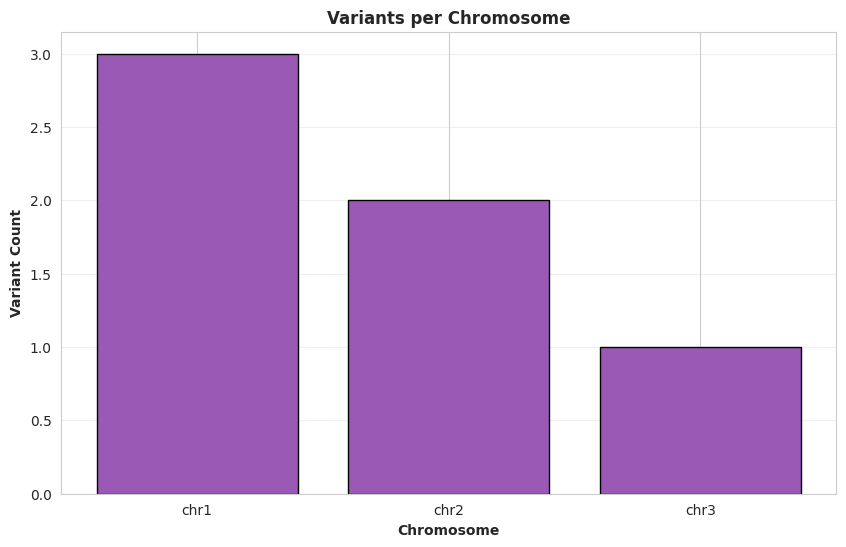

In [13]:
# Chromosome distribution
chrom_counts = df['CHROM'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(range(len(chrom_counts)), chrom_counts.values, color='#9b59b6', edgecolor='black')
plt.xticks(range(len(chrom_counts)), chrom_counts.index)
plt.xlabel('Chromosome', fontweight='bold')
plt.ylabel('Variant Count', fontweight='bold')
plt.title('Variants per Chromosome', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [14]:
# Transition/Transversion ratio
def classify_snp(ref, alt):
    transitions = [('A','G'), ('G','A'), ('C','T'), ('T','C')]
    return 'Ts' if (ref, alt) in transitions else 'Tv'

ts = tv = 0
for _, row in df.iterrows():
    if len(row['REF']) == 1 and len(row['ALT']) == 1:
        if classify_snp(row['REF'], row['ALT']) == 'Ts':
            ts += 1
        else:
            tv += 1

ratio = ts/tv if tv > 0 else 0
print(f"Transitions: {ts}")
print(f"Transversions: {tv}")
print(f"Ts/Tv ratio: {ratio:.2f}")
print("\nExpected: ~2.0 (genome), ~3.0 (exome)")

Transitions: 4
Transversions: 2
Ts/Tv ratio: 2.00

Expected: ~2.0 (genome), ~3.0 (exome)


In [15]:
# Complete pipeline
def analyze_pipeline(vcf_file):
    print("="*60)
    print("VARIANT ANALYSIS PIPELINE")
    print("="*60)

    df = vcf_to_df(vcf_file)
    print(f"\n[1] Loaded {len(df)} variants")

    hq = df[(df['QUAL'] >= 50) & (df['FILTER'] == 'PASS')]
    print(f"[2] High-quality: {len(hq)}")

    effects = df['EFFECT'].value_counts()
    print(f"[3] Effects: {dict(effects)}")

    genes = df['GENE'].value_counts()
    print(f"[4] Genes: {len(genes)}")

    hq.to_csv('high_quality.csv', index=False)
    print("[5] Saved results")

    print("\n✅ Complete!")
    return {'total': len(df), 'hq': len(hq)}

results = analyze_pipeline('variants.vcf')
print(f"\nSummary: {results}")

VARIANT ANALYSIS PIPELINE

[1] Loaded 6 variants
[2] High-quality: 4
[3] Effects: {'missense': np.int64(2), 'synonymous': np.int64(1), 'nonsense': np.int64(1), 'intron': np.int64(1), '5UTR': np.int64(1)}
[4] Genes: 6
[5] Saved results

✅ Complete!

Summary: {'total': 6, 'hq': 4}


In [16]:
# Disease gene analysis
cancer_genes = ['BRCA1', 'TP53', 'KRAS', 'EGFR', 'BRAF', 'MYC']
pathogenic = df[
    (df['GENE'].isin(cancer_genes)) &
    (df['EFFECT'].isin(['missense', 'nonsense'])) &
    (df['QUAL'] >= 50)
]

print("Pathogenic Candidates:")
for _, v in pathogenic.iterrows():
    print(f"\n🔴 {v['GENE']} - {v['ID']}")
    print(f"   {v['CHROM']}:{v['POS']} {v['REF']}>{v['ALT']}")
    print(f"   Effect: {v['EFFECT']}, AF: {v['AF']:.3f}")
    if v['AF'] < 0.01:
        print("   ⚠️ RARE variant")

Pathogenic Candidates:

🔴 EGFR - rs345
   chr1:34567 G>A
   Effect: nonsense, AF: 0.180

🔴 KRAS - rs456
   chr2:45678 T>C
   Effect: missense, AF: 0.550


## Exercises

### Exercise 1
Filter variants with Q>100, DP>150, AF between 0.1-0.5

In [17]:
# Your code


### Exercise 2
Calculate average quality per effect type

In [18]:
# Your code


### Exercise 3
Compare TP53 vs KRAS variants

In [ ]:
# Your code


## Summary

✅ VCF file handling  
✅ Quality filtering  
✅ Effect annotation  
✅ Population genetics  
✅ Visualizations  
✅ Clinical analysis  

### Resources
- [dbSNP](https://www.ncbi.nlm.nih.gov/snp/)
- [ClinVar](https://www.ncbi.nlm.nih.gov/clinvar/)
- [VEP](https://www.ensembl.org/vep)
- [PyVCF](https://pyvcf.readthedocs.io/)